# Building a prediction model for the final selling price of the auctions

IMPORTANT REMARK:

This code shall be executed from start to finish in the defined order. Errors may occur if the cells are executed in a different order.

In [41]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
    
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

from sklearn import preprocessing

In this section, different prediction models to predict the final selling price of an auction before it starts have been built. The predictions are made with the intention that having an estimation of the final selling price of an auction could be very helpful for auction business owners (in this case Swoopo).

Since the final selling price of an auction item is obtained by multiplying the bid price increment for that auction and the number of bids placed, and the bid price increment for an auction is known data, we are also indirectly predicting the number of bids placed for the auction. Swoopo's gain is obtained by multiplying the number of bids placed (predicted) and the bid fee (known data), and summing the result to the final price of the auction (predicted). Therefore, Swoopo's gain is also being indirectly predicted. Swoopo's profit would be calculated as the difference between the gain (predicted) and the retail price of the item (known data).

In [42]:
outcomesDf = pd.read_csv('./outcomes_clean.tsv',sep='\t')
outcomesDf.head(1)

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,...,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice,bids_placed,swoopo_sale_price,swoopo_profit,winner_benefit
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,0.15,0.75,Racer11,...,0,2008-09-16 19:52:00,0,0,0,0,89.0,77.060489,-422.929511,467.14


The columns that are given as input for the prediction model are: "retail" (the retail price of the item), "bidincrement" (the bid increment), "bidfee" (the bid fee), and the flags that indicate whether the auction is a click-only auction, a beginner auction, a fixed-price auction or and end-price auction. 

The retail price of the item will clearly influence the final price that the auction reaches (in general, users will place more bids for more expensive items). The bid increment directly influences the final price that the auction reaches, because the last one is calculated by multiplying the bid increment and the number of bids placed in the auction. The bid fee will also influence the final price of the item, since users will be willing to place more bids if the bid fee is low, and placing more bids implies that the final price reached increases. The flags indicating the type of auction might have an influence for some users on whether they are willing to place more or less bids for the auction, so that is why they have been included.

In [43]:
x_column_names = ["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]

The "auction_id" (auction id) column has not been included as an input variable for the model because it is unique for each auction, and therefore, it does not provide any useful information for the predictions.

The columns "product_id" (product id), "desc" (product description) and "item" have not been included as input for the model either. The product that is being sold (i.e., the product id) can certainly influence the final price that the auction reaches, but if we were to include this variable as input for the model, we would have to one-hot encode it, as it is expressed as a number, but there is no actual order defined for the values that it contains (a product with a larger product id than another one is not "larger" than that product. The number is just used as an identifier). If we were to include the other two columns ("desc", containing the product description, and "item", containing an item string associated to the product), they would also have to be one-hot encoded.

As it can be seen, all of these columns contain many unique values. In the previous section, the item categories have been obtained from Amazon, and have been converted into a Word2Vec vector. The distances that these vectors define can be used to create clusters for the product categories that can be used as input for the prediction models rather than the other mentioned columns (which contain way too many different values, and the prediction model would not be able to generalize well if we used them as input variables to express diferences between the type of auctioned items).

In [44]:
print(len(outcomesDf["product_id"].unique()))
print(len(outcomesDf["desc"].unique()))
print(len(outcomesDf["item"].unique()))

2080
1769
1767


The columns "price" and "finalprice" contain the final selling price reached for the auction (with a small difference between each other that will later be reminded), which is exactly what we want to predict, and therefore, they cannot be an input for the prediction model.

The columns "winner" (winner of the auction) 'placedbids' (number of paid bids placed by the winnner of the auction), "freebids" (number of free bids placed by the winner of the auction) and "endtime_str' (time in which the auction finished) contain information that is not known until the auction finishes, and therefore, they cannot be used as input for the model to predict the final selling price before the auction starts.

The same thing happens with the other columns that were added in previous sections to the dataset: "bids_placed" (total number of bids placed for the auction), "swoopo_sale_price" (total gain obtained by Swoopo for the auction), "swoopo_profit" (total profit obtained by Swoopo for the auction, calculated as the gain obtained minus the retail price of the item), and "winner_benefit" (the difference between the money paid by the winner for the item and the retail price of the item). They cannot be used as input data for the model because they contain data that is not known at the beginning of the auction (and also, even if the data was known at the beginning of the auction, they have been calculated using the values of the other variables, so they could lead to multicollinearity problems if they were included in that case).

The columns "flg_fixedprice" and "flg_endprice" indicate whether the auction is a fixed-price auction or and end-price auction. Fixed-price actions are auctions for which the final selling price of the item is set from the beginning. End-price auctions are auctions in which the final selling price of the item is zero independently of the bids that are placed, and the revenue for Swoopo comes exclusively from the bids that are placed).

The column "finalprice" contains the real final selling price of the auction (that is, the fixed price for fixed-price auctions and zero for end-price auctions), while the "price" column contains the selling price of the auction calculated as the number of bids placed multiplied by the bid increment. Since the final selling price is already known from the beginning for fixed-price auctions and end-price auctions, and we are interested in knowing the gain that the auction provides for Swoopo, it has been chosen to predict the value in column "price".

In [45]:
X = outcomesDf[x_column_names]
y = outcomesDf["price"]

# a) Single model - Without having into account the product categories

The first models that have been built do not take into account the product categories. The input variables for the model are: the retail price of the item, the bid increment, the bid fee, and the flags that indicate whether the auction is a click-only auction, a beginner auction, a fixed-price auction or and end-price auction.

In order to be able to compare the results for different models, it has been chosen to develop the following ones: a random forest regressor, a k-neighbors regressor, a decision tree regressor, a linear regression and a RANSAC regressor.

The dataset has been divided into different parts for the training and the testing phases, and 5-fold cross-validation has been applied so that the resulting quality metrics are more reliable.

The metrics that have been calculated are the mean absolute error and the median absolute error. 

The mean absolute error gives an idea about the error that the model incurs in when performing final price predictions for individual auctions. Nevertheless, the final selling price of an auction depends on a lot of things: the users that are monitoring the auction, the amount of money that they have and their interests at the moment of the auction, etc.

Even when the item that is auctioned is the same one, the final price that is reached for each one of the auctions can be very different. As an example:

In [46]:
outcomesDf[outcomesDf["desc"] == "Sony Ericsson S500i Unlocked Mysterious Green"][["desc","finalprice"]].head(15)

,desc,finalprice
0,Sony Ericsson S500i Unlocked Mysterious Green,13.35
3,Sony Ericsson S500i Unlocked Mysterious Green,19.65
4,Sony Ericsson S500i Unlocked Mysterious Green,47.10
5,Sony Ericsson S500i Unlocked Mysterious Green,55.20
6,Sony Ericsson S500i Unlocked Mysterious Green,86.10
17,Sony Ericsson S500i Unlocked Mysterious Green,48.60
18,Sony Ericsson S500i Unlocked Mysterious Green,113.10
48,Sony Ericsson S500i Unlocked Mysterious Green,75.15
49,Sony Ericsson S500i Unlocked Mysterious Green,35.10
50,Sony Ericsson S500i Unlocked Mysterious Green,19.20


The most extreme values could be considered outliers and be removed from the dataset so that they do not negatively influence the model. However, in this case, the extreme values are legitimate observations and they are most likely not incorrectly entered data. Therefore, instead of removing them, it has been decided to include some prediction models that are robust to outliers. For example, random forests and decision trees isolate atypical observations into small leaves, and the RANSAC algorithm provides a robust linear model estimation.

Because of the high variance of the final selling price of the auctions, appart from the mean absolute error, it has also been decided to use the median absolute error as a metric. This metric is not be so highly influenced by extreme values. Making final selling price predictions can help Swoopo or similar businesses to have an estimation of the money that they will earn before a group of auctions start. However, we consider it more important to have an accurate estimation of groups of several auctions (for example, accurate weekly or monthly profit estimations, which can be calculated by using the estimations of the final price of the auctions included in those time periods), rather than accurate estimations for individual auctions, since Swoopo will profit of the total result of all of their auctions. Because of this reason, although the mean absolute error has been calculated, the median absolute error is considered to be a more appropiate metric in this case.

The mean absolute percentage error (MAPE) has also been considered as a metric. Nevertheless, if a video game is predicted to reach a selling price of 20\$, and the real selling price ends up being 30\$,the MAPE would be 33%. However, if a laptop is predicted to reach a selling price of 700\$ and the real selling price ends up being 800\$, the MAPE is only 12.50%, but there is a prediction error of 100\$ between the predicted price and the final price, which can have a higher impact in the business than the error in the video game prediction. For this reason, it has been decided not to use a metric that indicates a percentage.

As mentioned before, in this section, the models that have been built do not take into account the product categories. The input variables for the models are: the retail price of the item, the bid increment, the bid fee, and the flags that indicate whether the auction is a click-only auction, a beginner auction, a fixed-price auction or and end-price auction.

The following code is used to calculate the mean absolute error and the median absolute error (as the average of the results obtained for these two metrics over the 5 cross-validation folds) for the previously mentioned models. The results are analyzed after the lines of code.

In [47]:
kFoldMedianAbsoluteErrorsRandomForestRegressor = []
kFoldMedianAbsoluteErrorsKNeighborsRegressor = []
kFoldMedianAbsoluteErrorsDecisionTreeRegressor = []
kFoldMedianAbsoluteErrorsLinearRegression = []
kFoldMedianAbsoluteErrorsRANSACRegressor = []

kFoldMeanAbsoluteErrorsRandomForestRegressor = []
kFoldMeanAbsoluteErrorsKNeighborsRegressor = []
kFoldMeanAbsoluteErrorsDecisionTreeRegressor = []
kFoldMeanAbsoluteErrorsLinearRegression = []
kFoldMeanAbsoluteErrorsRANSACRegressor = []

kFoldNumber = 1
kf = KFold(n_splits=5, random_state=1)
for train_index, test_index in kf.split(X):
    #5-fold cross-validation
    print("Executing k fold = "+str(kFoldNumber))
    kFoldNumber=kFoldNumber+1
    
    #train and test split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #RandomForestRegressor
    model=RandomForestRegressor(random_state=1)
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsRandomForestRegressor.append(kFoldMedianAbsoluteError)    
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsRandomForestRegressor.append(kFoldMeanAbsoluteError)  

    #KNeighborsRegressor
    model = KNeighborsRegressor()
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsKNeighborsRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsKNeighborsRegressor.append(kFoldMeanAbsoluteError)
    
    #DecisionTreeRegressor
    model = DecisionTreeRegressor()
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsDecisionTreeRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsDecisionTreeRegressor.append(kFoldMeanAbsoluteError)
    
    #LinearRegression
    model = LinearRegression()
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsLinearRegression.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsLinearRegression.append(kFoldMeanAbsoluteError)
    
    #RANSACRegressor
    model = RANSACRegressor(random_state=1)
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsRANSACRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsRANSACRegressor.append(kFoldMeanAbsoluteError)
    
medianAbsoluteErrorsRandomForestRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsRandomForestRegressor)
meanAbsoluteErrorsRandomForestRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsRandomForestRegressor)
medianAbsoluteErrorsKNeighborsRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsKNeighborsRegressor)
meanAbsoluteErrorsKNeighborsRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsKNeighborsRegressor)
medianAbsoluteErrorsDecisionTreeRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsDecisionTreeRegressor)
meanAbsoluteErrorsDecisionTreeRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsDecisionTreeRegressor)
medianAbsoluteErrorsLinearRegressionAverage = np.mean(kFoldMedianAbsoluteErrorsLinearRegression)
meanAbsoluteErrorsLinearRegressionAverage = np.mean(kFoldMeanAbsoluteErrorsLinearRegression)
medianAbsoluteErrorsRANSACRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsRANSACRegressor)
meanAbsoluteErrorsRANSACRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsRANSACRegressor)

print("--")
print("Random Forest Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsRandomForestRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsRandomForestRegressorAverage))
print("--")
print("K Neighbors Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsKNeighborsRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsKNeighborsRegressorAverage))
print("--")
print("Decision Tree Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsDecisionTreeRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsDecisionTreeRegressorAverage))
print("--")
print("Linear Regression")
print("Median absolute error: "+str(medianAbsoluteErrorsLinearRegressionAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsLinearRegressionAverage))
print("--")
print("RANSAC Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsRANSACRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsRANSACRegressorAverage))

Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
--
Random Forest Regressor
Median absolute error: 11.1752458141
Mean absolute error: 29.3445832716
--
K Neighbors Regressor
Median absolute error: 11.9772
Mean absolute error: 31.8406889199
--
Decision Tree Regressor
Median absolute error: 11.0488437347
Mean absolute error: 29.7480416922
--
Linear Regression
Median absolute error: 24.2493912238
Mean absolute error: 42.0046659273
--
RANSAC Regressor
Median absolute error: 10.4691486861
Mean absolute error: 38.1582942494


As it can be seen above, the model with the best results in terms of the median absolute error is the RANSAC regressor. Nevertheless, its mean absolute error is much higher than for other models, which indicates that the deviation between individual prediction results and real results is higher than for other models. The decision tree regresor and the random forest regressor both present good results for the two metrics. The k-neighbors regressor performs alright, but worse than the other two. The worst results are obtained with the linear regression, probably because it is more sensitive to outliers than the others.

# b) Single Model - Clustering by product categories

A second set of models that have into account the product categories have been built. As specified in previous sections, with the use of the product description available for each product in the column "desc" of the dataset, the Amazon product category has been obtained. A word embedding vector representing the product category has been calculated based on Google's pre-trained Word2Vec model. The distances defined by these vectors can be used to perform a distance-based clustering. For these models, a K-Means clustering has been used to group the products belonging to semantically similar categories.

The idea behind categorizing the products is that, if the final selling price of the items have similar patterns for similar products, a prediction model will perform better if a grouping based on the product categories is given as input. In this case, the input is the cluster identifier that each product belongs to. Since this is a categorical integer feature, a one-hot encoder has been used.

Therefore, for this set of models, the input variables are: the retail price of the item, the bid increment, the bid fee, the flags that indicate the type of auction, and the one-hot encoded cluster identifier. The prediction models and the metrics are the same as in the previous part.

One thing to take into account for these set of models is that they require a preprocessing step that has to be performed both for the training data and the test data. This preprocessing step consists on, given the product description of an item in the column "desc", its Amazon category must be obtained, and afterwards, the corresponding word embedding vector.

Also, the product category clustering must be performed with the training data. Each product appearing in the test data is then assigned one of the clusters obtained during the training part. The cluster that it is assigned to is the nearest one (according to the distance defined by the word embedding vector of the product appearing in the test data).

In [48]:
outcomesDf = pd.read_csv('./outcomes_clean.tsv',sep='\t')

The following file contains the word embedding vectors associated to each product in the dataset that have been calculated in previous sections. If the prediction models were to be used in real life, a word embedding vector would have to be calculated for each new product following the procedure explained in previous sections.

In [49]:
productDescriptionToVectorDf = pd.read_excel('./productDescriptionToVector.xlsx')

The following function is given as input a DataFrame that contains the cluster assigned to each product. The output of the function is the one-hot encoded version of the DataFrame given as input.

In [50]:
def convertCategoryDataFrameToOneHotEncodedVersion(clusteredCategoriesDf, categoryColumnName, trainClusterColumNames = None):
    #categories assigned to each row of the DataFrame
    categories = clusteredCategoriesDf[categoryColumnName]
    onehot_encoder = OneHotEncoder(sparse=False)
    categories = categories.values.reshape(len(categories), 1)
    #One-Hot encoded version of the categories, where each column represents a category,
    #and each row has the value "1" on the column of the category that it belongs to,
    #and "0" on the other columns.
    onehot_encoded = onehot_encoder.fit_transform(categories)
    ncolumns = np.shape(onehot_encoded)[1]
    #array that will contain the column names for the category clusters
    clusterColumNames = ['cluster_']*ncolumns
    for clusterNumber in np.arange(ncolumns):
        #each column name is "cluster_" followed by the cluster number
        clusterColumNames[clusterNumber] += str(clusterNumber)

    #One-Hot Encoded DataFrame
    clusteredCategoriesDfOneHotEnc = pd.DataFrame(onehot_encoded,columns=clusterColumNames)
    
    if trainClusterColumNames is not None:
        #this function is called both in the training phase and the testing phase.
        #For the training phase, trainClusterColumNames = None
        #For the testing phase, trainClusterColumNames contains the column names
        #of the One-Hot encoded DataFrame obtained during the training phase.
        for trainColumnName in trainClusterColumNames:
            if trainColumnName not in clusterColumNames:
                #It may happen that a product category that appeared in the training phase
                #does not appear in the testing phase. However, since the model is given 
                #the training One-Hot encoded DataFrame column values as input, it is necessary
                #that the testing One-Hot encoded DataFrame contains the same columns
                
                #Therefore, if a category that appeared in the training phase does not
                #appear in the testing phase, a column filled in with "0" for all rows
                #is created.
                clusteredCategoriesDfOneHotEnc[trainColumnName] = 0.0
            
    return clusteredCategoriesDfOneHotEnc

In the same way as in the previous set of models, the following lines of code calculate the metrics associated to each one of the prediction models using 5-fold cross-validation.

During the training part, the K-Means algorithm is used to obtain clusters for the word embedding vectors. 

The dataset contains several auctions in which the same item was auctioned. For example:

In [51]:
outcomesDf[outcomesDf["desc"] == "Sony Ericsson S500i Unlocked Mysterious Green"].head(10)

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,...,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice,bids_placed,swoopo_sale_price,swoopo_profit,winner_benefit
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,0.15,0.75,Racer11,...,0,2008-09-16 19:52:00,0,0,0,0,89.0,77.060489,-422.929511,467.14
3,88638,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,19.65,19.65,0.15,0.75,Mokkis,...,0,2008-08-23 22:02:00,0,0,0,0,131.0,113.426113,-386.563887,472.84
4,88639,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,47.10,47.10,0.15,0.75,Superloeffel,...,0,2008-08-24 14:23:00,0,0,0,0,314.0,271.876331,-228.113669,392.89
5,88693,10008975,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,55.20,55.20,0.15,0.75,Danydemir80,...,13,2008-08-22 22:44:00,0,0,0,0,368.0,318.632133,-181.357867,444.79
6,88694,10008975,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,86.10,86.10,0.15,0.75,Destination8,...,0,2008-08-24 07:10:00,0,0,0,0,574.0,496.996860,-2.993140,371.14
17,90526,10009642,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,48.60,48.60,0.15,0.75,Wadenbeisser,...,0,2008-09-02 00:06:00,0,0,0,0,324.0,280.534813,-219.455187,431.89
18,90527,10009642,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,113.10,113.10,0.15,0.75,Vonluxburg,...,0,2008-09-04 02:27:00,0,0,0,0,754.0,652.849533,152.859533,172.39
48,92708,10009642,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,75.15,75.15,0.15,0.75,pauli55,...,0,2008-08-25 15:12:00,0,0,0,0,501.0,433.789942,-66.200058,290.59
49,92709,10009642,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,35.10,35.10,0.15,0.75,Voovoo3,...,0,2008-09-05 22:33:00,0,0,0,0,234.0,202.608476,-297.381524,459.64
50,92723,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,19.20,19.20,0.15,0.75,barrakuda,...,0,2008-09-20 18:35:00,0,0,0,0,128.0,110.828568,-389.161432,444.04


Since the item that is auctioned is the same in these cases, the description of the item (and so, its word embedding vector) is the same. In each iteration, the K-Means algorithm assigns every data point to the nearest centroid. Replication of data points (the word embedding vectors in this case) influences the centroids of the clusters.

The objective of this clustering is to provide the prediction model with a grouping of the items according to their categories, so that it is easier for the model to find a pattern (if it exists) within products belonging to the same category. Duplicated items have been removed from the input data given to the clustering algorithm so that each different product has the same weight for the product category clustering.

The duplicated items have instead not been removed from the input data given to the prediction algorithms, so that the weight of the evidence is higher on cases of duplication.

Once that each different item has been assigned a cluster, a DataFrame containing the product description and the corresponding cluster number is created. This DataFrame is given as input for the function explained above, which returns the one-hot encoded version of the DataFrame. The input variables for the prediction models are the retail price of the item, the bid increment, the bid fee, the flags that indicate the type of auction, and the one-hot encoded cluster identifier.

Then, for each row contained in the test data, the word embedding vector associated to the product description is obtained. Then, the nearest cluster (according to the distance defined by the word embedding vector) obtained during the training part is assigned to the product. This process is done for all rows of the test data, and then, in the same way as in the training part, a one-hot encoded version of the DataFrame containing the product description and the corresponding cluster number is obtained.





The mean absolute error and the median absolute error (as the average of the results obtained for these two metrics over the 5 cross-validation folds) is then calculated for each prediction model. The results are analyzed after the lines of code.

In [52]:
kFoldMedianAbsoluteErrorsRandomForestRegressor = []
kFoldMedianAbsoluteErrorsKNeighborsRegressor = []
kFoldMedianAbsoluteErrorsDecisionTreeRegressor = []
kFoldMedianAbsoluteErrorsLinearRegression = []
kFoldMedianAbsoluteErrorsRANSACRegressor = []

kFoldMeanAbsoluteErrorsRandomForestRegressor = []
kFoldMeanAbsoluteErrorsKNeighborsRegressor = []
kFoldMeanAbsoluteErrorsDecisionTreeRegressor = []
kFoldMeanAbsoluteErrorsLinearRegression = []
kFoldMeanAbsoluteErrorsRANSACRegressor = []

kFoldNumber = 1
kf = KFold(n_splits=5, random_state=1)
for train_index, test_index in kf.split(outcomesDf):
    #5-fold cross-validation
    print("Executing k fold = "+str(kFoldNumber))
    kFoldNumber=kFoldNumber+1
    
    #train and test split
    outcomesDf_train, outcomesDf_test = outcomesDf.iloc[train_index], outcomesDf.iloc[test_index]   
    
    #TRAINING PART
    
    #Unique product descriptions present in the training dataset
    productDescriptionTrain = outcomesDf_train['desc'].unique()
    
    productDescriptionToVector={}
    for item in productDescriptionTrain:
        #Word2Vec vector obtained for each product description
        productDescriptionToVector[item] = productDescriptionToVectorDf[item]
    
    productVectors = list(productDescriptionToVector.values())
   
    km = KMeans(n_clusters=20,random_state=2)
    #the clustering is performed with the Word2Vec vectors for the product categories given as input
    km.fit(productVectors)
    clusters = km.labels_.tolist()
    #DataFrame containing columns for the product description and the category cluster that it is associated to
    clusteredCategoriesDf = pd.DataFrame({'desc': list(productDescriptionToVector.keys()), 'cat_cluster': clusters})
    #One-Hot encoded version of the DataFrame containing a column for each cluster
    clusteredCategoriesDfOneHotEnc = convertCategoryDataFrameToOneHotEncodedVersion(clusteredCategoriesDf,'cat_cluster')  
    #column names of the clusters
    cluster_column_names = clusteredCategoriesDfOneHotEnc.columns.values
    clusteredCategoriesDfOneHotEnc['desc'] = clusteredCategoriesDf['desc']
    #the training dataset is merged so that it contains a one hot-encoded 
    #column for each one of the clusters obtained.
    outcomesDfWithCatOneHot = outcomesDf_train.merge(clusteredCategoriesDfOneHotEnc,how='left')
    normal_x_column_names = ["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]
    #column names to be used in the prediction model: they include the columns corresponding to the clusters obtained.
    column_names_with_clusters = np.concatenate([normal_x_column_names,cluster_column_names])
    
    #training phase variables
    X_train = outcomesDfWithCatOneHot[column_names_with_clusters]
    y_train = outcomesDfWithCatOneHot["price"]
    
    #TEST PART
    
    #Unique product descriptions present in the training dataset
    productDescriptionTest = outcomesDf_test['desc'].unique()
    
    productDescriptionToVector={}
    for item in productDescriptionTest:
        #Word2Vec vector obtained for each product description
        productDescriptionToVector[item] = productDescriptionToVectorDf[item]
   
    productDescriptionToTrainCluster = {}
    for productDescription, vector in productDescriptionToVector.items():
        #The K-Means model obtained during the training phase is used to associate
        #an existing cluster to each one of the product vectors contained in the test data.
        clusterCategory = km.predict([vector])
        productDescriptionToTrainCluster[productDescription] = clusterCategory[0]
    
    #DataFrame containing columns for the product description and the category cluster that it is associated to
    clusteredCategoriesDf = pd.DataFrame(list(productDescriptionToTrainCluster.items()), columns=['desc', 'cat_cluster'])
    #One-Hot encoded version of the DataFrame containing a column for each cluster.
    #The columns are the same ones as in the training phase
    clusteredCategoriesDfOneHotEnc = convertCategoryDataFrameToOneHotEncodedVersion(clusteredCategoriesDf,'cat_cluster',cluster_column_names)
    #column names of the clusters
    cluster_column_names = clusteredCategoriesDfOneHotEnc.columns.values
    clusteredCategoriesDfOneHotEnc['desc'] = clusteredCategoriesDf['desc']
    #the test dataset is merged so that it contains a one hot-encoded 
    #column for each one of the clusters obtained.
    outcomesDfWithCatOneHot = outcomesDf_test.merge(clusteredCategoriesDfOneHotEnc,how='left')
    normal_x_column_names = ["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]
    #column names to be used in the prediction model: they include the columns corresponding to the clusters obtained.
    column_names_with_clusters = np.concatenate([normal_x_column_names,cluster_column_names])
    
    #test phase variables
    X_test = outcomesDfWithCatOneHot[column_names_with_clusters]
    y_test = outcomesDfWithCatOneHot["price"]
    
    #Predictors
    
    #RandomForestRegressor
    model=RandomForestRegressor(random_state=1)
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsRandomForestRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsRandomForestRegressor.append(kFoldMeanAbsoluteError)  

    #KNeighborsRegressor
    model = KNeighborsRegressor()
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsKNeighborsRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsKNeighborsRegressor.append(kFoldMeanAbsoluteError)  
    
    #DecisionTreeRegressor
    model = DecisionTreeRegressor()
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsDecisionTreeRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsDecisionTreeRegressor.append(kFoldMeanAbsoluteError)  
    
    #LinearRegression
    model = LinearRegression()
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsLinearRegression.append(kFoldMedianAbsoluteError) 
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsLinearRegression.append(kFoldMeanAbsoluteError)  
    
    #RANSACRegressor
    model = RANSACRegressor(random_state=1)
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsRANSACRegressor.append(kFoldMedianAbsoluteError) 
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsRANSACRegressor.append(kFoldMeanAbsoluteError)  
    
medianAbsoluteErrorsRandomForestRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsRandomForestRegressor)
meanAbsoluteErrorsRandomForestRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsRandomForestRegressor)
medianAbsoluteErrorsKNeighborsRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsKNeighborsRegressor)
meanAbsoluteErrorsKNeighborsRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsKNeighborsRegressor)
medianAbsoluteErrorsDecisionTreeRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsDecisionTreeRegressor)
meanAbsoluteErrorsDecisionTreeRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsDecisionTreeRegressor)
medianAbsoluteErrorsLinearRegressionAverage = np.mean(kFoldMedianAbsoluteErrorsLinearRegression)
meanAbsoluteErrorsLinearRegressionAverage = np.mean(kFoldMeanAbsoluteErrorsLinearRegression)
medianAbsoluteErrorsRANSACRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsRANSACRegressor)
meanAbsoluteErrorsRANSACRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsRANSACRegressor)

print("--")
print("Random Forest Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsRandomForestRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsRandomForestRegressorAverage))
print("--")
print("K Neighbors Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsKNeighborsRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsKNeighborsRegressorAverage))
print("--")
print("Decision Tree Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsDecisionTreeRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsDecisionTreeRegressorAverage))
print("--")
print("Linear Regression")
print("Median absolute error: "+str(medianAbsoluteErrorsLinearRegressionAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsLinearRegressionAverage))
print("--")
print("RANSAC Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsRANSACRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsRANSACRegressorAverage))

Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
--
Random Forest Regressor
Median absolute error: 10.3695943096
Mean absolute error: 28.2917930555
--
K Neighbors Regressor
Median absolute error: 11.0048
Mean absolute error: 31.3873834655
--
Decision Tree Regressor
Median absolute error: 10.4463348686
Mean absolute error: 28.9819960038
--
Linear Regression
Median absolute error: 21.5956271431
Mean absolute error: 39.2957860884
--
RANSAC Regressor
Median absolute error: 15.2715519949
Mean absolute error: 44.8184361425


As it can be seen above, the model with the best results is the random forest regressor, both in terms of the median absolute error and the mean absolute error. It is closely followed by the decision tree regressor. Although the random forest regressor performs better in terms of the chosen metrics, the decision tree regressor is easier to interpret. Nevertheless, the decision tree regressor is also more likely to overfit the data. The k-neighbors regressor is the next one with the better results, followed by the RANSAC regressor. Ultimatelly, the worst results are obtained with the linear regression.

In general, the results are better with this set of models that takes into account the product categories as compared with the results obtained with the set of models that does not take them into account (explained in the previous section).

Nevertheless, this set of models requires a bigger effort, since a preprocessing step is necessary to make predictions. This preprocessing step consists on, given the product description of an item in the column "desc", its Amazon category must be obtained, and afterwards, the corresponding word embedding vector.

Furthermore, during the training part of the model, the product category clusters are obtained, and these clusters are the ones that are used each time that a new prediction is made. After some time, more and more new products will begin to be auctioned, which will not have been considered to form the clusters. Because of this, the clusters may eventually become outdated, and the models will perform worse. Therefore, appart from the preprocessing step, using the product categories also involves having to retrain the prediction models more often.

# c) Multiple models - Clustering by product categories

A third set of models that have into account the product categories has been built. The difference between this set of models and the previous one is that instead of using a single model for all items, a different prediction model is used for each different product category (i.e., each cluster).

In [53]:
outcomesDf = pd.read_csv('./outcomes_clean.tsv',sep='\t')

In [54]:
productDescriptionToVectorDf = pd.read_excel('./productDescriptionToVector.xlsx')

In the same way as in the previous set of models, the following lines of code calculate the metrics associated to each one of the prediction models using 5-fold cross-validation. During the training part, the K-Means algorithm is used to obtain clusters for the word embedding vectors. Once that each different item in the training data has been assigned to a cluster, the training data is divided by cluster number. For each set of data belonging to the same cluster, a new set of prediction models is trained. The input variables for the model are the retail price of the item, the bid increment, the bid fee and the flags that indicate the type of auction.

During the test part, for each row contained in the test data, the word embedding vector associated to the product description is obtained. Then, the nearest cluster (according to the distance defined by the word embedding vector) obtained during the training part is assigned to the product. For each row contained in the test data, the corresponding set of models for that product category (cluster) is used to make the selling price prediction.

The mean absolute error and the median absolute error (as the average of the results obtained for these two metrics over the 5 cross-validation folds) is then calculated for each prediction model contained in the different sets assigned to each cluster. For each type of prediction model (random forest regressor, decision tree regressor, etc), the mean absolute error and the median absolute error is calculated as the average of the results obtained for each one of the models (with the same type of prediction algorithm) corresponding to each different cluster. The results are analyzed after the lines of code.

In [55]:
kFoldMedianAbsoluteErrorsRandomForestRegressor = []
kFoldMedianAbsoluteErrorsKNeighborsRegressor = []
kFoldMedianAbsoluteErrorsDecisionTreeRegressor = []
kFoldMedianAbsoluteErrorsLinearRegression = []
kFoldMedianAbsoluteErrorsRANSACRegressor = []

kFoldMeanAbsoluteErrorsRandomForestRegressor = []
kFoldMeanAbsoluteErrorsKNeighborsRegressor = []
kFoldMeanAbsoluteErrorsDecisionTreeRegressor = []
kFoldMeanAbsoluteErrorsLinearRegression = []
kFoldMeanAbsoluteErrorsRANSACRegressor = []

kf = KFold(n_splits=5, random_state=1)
kFoldNumber = 1
for train_index, test_index in kf.split(outcomesDf):
    #5-fold cross-validation
    print("Executing k fold = "+str(kFoldNumber))
    kFoldNumber=kFoldNumber+1
    
    #train and test split
    outcomesDf_train, outcomesDf_test = outcomesDf.iloc[train_index], outcomesDf.iloc[test_index]   
    
    #TRAINING PART
                                        
    #Unique product descriptions present in the training dataset
    productDescriptionTrain = outcomesDf_train['desc'].unique()
    
    productDescriptionToVector={}
    for item in productDescriptionTrain:
        #Word2Vec vector obtained for each product description
        productDescriptionToVector[item] = productDescriptionToVectorDf[item]
        
    productVectors = list(productDescriptionToVector.values())
    
    km = KMeans(n_clusters=15,random_state=2)
    #the clustering is performed with the Word2Vec vectors for the product categories given as input
    km.fit(productVectors)
    clusters = km.labels_.tolist()
    #DataFrame containing columns for the product description and the category cluster that it is associated to
    clusteredCategoriesDf = pd.DataFrame({'desc': list(productDescriptionToVector.keys()), 'cat_cluster': clusters})
    #the training dataset is merged and now it contains a column with the category that
    #each product belongs to.
    outcomesDfTrainAndCatCluster = outcomesDf_train.merge(clusteredCategoriesDf,how='left')
    
    clusterIndexToOutcomesDfTrain = {}
    for cluster_index in outcomesDfTrainAndCatCluster['cat_cluster'].unique():
        #the rows associated to each different product category are stored in a dictionary,
        #where the dictionary key is the product category number (cluster number)
        clusterIndexToOutcomesDfTrain[cluster_index] = outcomesDfTrainAndCatCluster[outcomesDfTrainAndCatCluster['cat_cluster'] == cluster_index]
    
    #dictionaries that contain a trained model for each one of the product categories (clusters)
    clusterIndexToRandomForestRegressor = {}
    clusterIndexToKNeighborsRegressor = {}
    clusterIndexToDecisionTreeRegressor = {}
    clusterIndexToLinearRegression = {}
    clusterIndexToRANSACRegressor = {}
    
    for cluster_index, outcomesDfClusterIndex in clusterIndexToOutcomesDfTrain.items():
        #For each product category (cluster), a different model is trained using
        #the rows of the input dataset containing the products associated to that category
        X_train = outcomesDfClusterIndex[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]].values
        y_train = outcomesDfClusterIndex["price"]
        
        #RandomForestRegressor
        model=RandomForestRegressor(random_state=1)
        model.fit(X_train,y_train)
        clusterIndexToRandomForestRegressor[cluster_index] = model

        #KNeighborsRegressor
        n_neighbors=5
        if outcomesDfClusterIndex.shape[0] < n_neighbors:
            #In KNeighborsRegressor it is expected n_neighbors <= n_samples
            n_neighbors = outcomesDfClusterIndex.shape[0]
            
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
        model.fit(X_train,y_train)
        clusterIndexToKNeighborsRegressor[cluster_index] = model

        #DecisionTreeRegressor
        model = DecisionTreeRegressor()
        model.fit(X_train,y_train)
        clusterIndexToDecisionTreeRegressor[cluster_index] = model
    
        #LinearRegression
        model = LinearRegression()
        model.fit(X_train,y_train)
        clusterIndexToLinearRegression[cluster_index] = model
        
        #RANSACRegressor
        model = RANSACRegressor(random_state=1)
        model.fit(X_train,y_train)
        clusterIndexToRANSACRegressor[cluster_index] = model
        
    #TEST PART
    
    #Unique product descriptions present in the test dataset
    productDescriptionTest = outcomesDf_test['desc'].unique()
    
    productDescriptionToVector={}
    for item in productDescriptionTest:
        #Word2Vec vector obtained for each product description
        productDescriptionToVector[item] = productDescriptionToVectorDf[item]
   
    productDescriptionToTrainCluster = {}
    for productDescription, vector in productDescriptionToVector.items(): 
        #The K-Means model obtained during the training phase is used to associate
        #an existing cluster to each one of the product vectors contained in the test data.        
        clusterCategory = km.predict([vector])
        productDescriptionToTrainCluster[productDescription] = clusterCategory[0]
    
    #DataFrame containing columns for the product description and the category cluster that it is associated to
    clusteredCategoriesDf = pd.DataFrame(list(productDescriptionToTrainCluster.items()), columns=['desc', 'cat_cluster'])
    #the test dataset is merged and now it contains a column with the category that
    #each product belongs to.
    outcomesDfTestAndCatCluster = outcomesDf_test.merge(clusteredCategoriesDf,how='left')
    
    realAndPredictedValuesRandomForestRegressor = []
    realAndPredictedValuesKNeighborsRegressor = []
    realAndPredictedValuesDecisionTreeRegressor = []
    realAndPredictedValuesLinearRegression = []
    realAndPredictedValuesRANSACRegressor = []
    
    for index, row in outcomesDfTestAndCatCluster.iterrows():
        #iteration through each row of the test dataset
        
        #real value of the column to be predicted
        y_test_value = row["price"]
        #values given as input for the prediction model
        x_test_value = row[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]].values
        #product category cluster for this row of the dataset
        clusterIndex = row["cat_cluster"]
        
        #the prediction models associated to this product category (cluster) are extracted
        modelRandomForestRegressor = clusterIndexToRandomForestRegressor[clusterIndex]
        modelKNeighborsRegressor = clusterIndexToKNeighborsRegressor[clusterIndex]
        modelDecisionTreeRegressor = clusterIndexToDecisionTreeRegressor[clusterIndex]
        modelLinearRegression = clusterIndexToLinearRegression[clusterIndex]
        modelRANSACRegressor = clusterIndexToRANSACRegressor[clusterIndex]
        
        #the real value and the predicted value are stored in a different list for
        #each one of the prediction models used.
        realAndPredictedValuesRandomForestRegressor.append((y_test_value,modelRandomForestRegressor.predict([x_test_value])[0]))
        realAndPredictedValuesKNeighborsRegressor.append((y_test_value,modelKNeighborsRegressor.predict([x_test_value])[0]))
        realAndPredictedValuesDecisionTreeRegressor.append((y_test_value,modelDecisionTreeRegressor.predict([x_test_value])[0]))
        realAndPredictedValuesLinearRegression.append((y_test_value,modelLinearRegression.predict([x_test_value])[0]))
        realAndPredictedValuesRANSACRegressor.append((y_test_value,modelRANSACRegressor.predict([x_test_value])[0]))
    
    #RandomForestRegressor
    #all real and predicted values are extracted and the metrics are calculated
    y_test, P_price = zip(*realAndPredictedValuesRandomForestRegressor)    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsRandomForestRegressor.append(kFoldMedianAbsoluteError) 
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsRandomForestRegressor.append(kFoldMeanAbsoluteError)  
    
    #KNeighborsRegressor
    #all real and predicted values are extracted and the metrics are calculated
    y_test, P_price = zip(*realAndPredictedValuesKNeighborsRegressor)    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsKNeighborsRegressor.append(kFoldMedianAbsoluteError)  
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsKNeighborsRegressor.append(kFoldMeanAbsoluteError)  
    
    #DecisionTreeRegressor
    #all real and predicted values are extracted and the metrics are calculated
    y_test, P_price = zip(*realAndPredictedValuesDecisionTreeRegressor)    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsDecisionTreeRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsDecisionTreeRegressor.append(kFoldMeanAbsoluteError)  
    
    #LinearRegression
    #all real and predicted values are extracted and the metrics are calculated
    y_test, P_price = zip(*realAndPredictedValuesLinearRegression)    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsLinearRegression.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsLinearRegression.append(kFoldMeanAbsoluteError) 
    
    #RANSACRegressor
    #all real and predicted values are extracted and the metrics are calculated
    y_test, P_price = zip(*realAndPredictedValuesRANSACRegressor)
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsRANSACRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsRANSACRegressor.append(kFoldMeanAbsoluteError) 
    
medianAbsoluteErrorsRandomForestRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsRandomForestRegressor)
meanAbsoluteErrorsRandomForestRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsRandomForestRegressor)
medianAbsoluteErrorsKNeighborsRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsKNeighborsRegressor)
meanAbsoluteErrorsKNeighborsRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsKNeighborsRegressor)
medianAbsoluteErrorsDecisionTreeRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsDecisionTreeRegressor)
meanAbsoluteErrorsDecisionTreeRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsDecisionTreeRegressor)
medianAbsoluteErrorsLinearRegressionAverage = np.mean(kFoldMedianAbsoluteErrorsLinearRegression)
meanAbsoluteErrorsLinearRegressionAverage = np.mean(kFoldMeanAbsoluteErrorsLinearRegression)
medianAbsoluteErrorsRANSACRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsRANSACRegressor)
meanAbsoluteErrorsRANSACRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsRANSACRegressor)

print("--")
print("Random Forest Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsRandomForestRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsRandomForestRegressorAverage))
print("--")
print("K Neighbors Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsKNeighborsRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsKNeighborsRegressorAverage))
print("--")
print("Decision Tree Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsDecisionTreeRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsDecisionTreeRegressorAverage))
print("--")
print("Linear Regression")
print("Median absolute error: "+str(medianAbsoluteErrorsLinearRegressionAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsLinearRegressionAverage))
print("--")
print("RANSAC Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsRANSACRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsRANSACRegressorAverage))

Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
--
Random Forest Regressor
Median absolute error: 10.3682931183
Mean absolute error: 28.429692278
--
K Neighbors Regressor
Median absolute error: 11.13
Mean absolute error: 30.7647559882
--
Decision Tree Regressor
Median absolute error: 10.4300171004
Mean absolute error: 28.9224769627
--
Linear Regression
Median absolute error: 16.4468950152
Mean absolute error: 33.9439732817
--
RANSAC Regressor
Median absolute error: 9.99884623609
Mean absolute error: 32.1491303303


As it can be seen above, the model with the best results in terms of the median absolute error is the RANSAC regressor. Nevertheless, the random forest regressor performs similarly in terms of the median absolute error, and performs way better in terms of the mean absolute error. It is closely followed by the decision tree regresor, which is easier to interpret but is also more likely to overfit the data. The k-neighbors regressor is the next one with the better results, followed by the linear regression with the worst results by far.

In general, the results are slightly better with this set of models as compared with the set of models explained in the previous section.

In terms of effort, this model requires the same preprocessing step to make predictions as the previous set of models: given the product description of an item in the column "desc", its Amazon category must be obtained, and afterwards, the corresponding word embedding vector.

A different prediction model is used for each different product category (cluster) that is obtained during the training part of the model. In the same way as with the set of models mentioned in the previous section, more and more new products will begin to be auctioned after some time, and the clusters (and therefore, the model assigned to each cluster) will become outdated and the models will perform worse. Therefore, appart from the preprocessing step, the prediction models have to be retrained after some time (and this time, it is not necessary to retrain a single model, but to retrain as many prediction models as existing clusters).

The decision between using a single model to make the predictions (as explained in the previous section), or using a different model for each product category (as explained in this section) should also be highly influenced by the amount of training data available. The data that is used to train the prediction model corresponding to a single cluster is only the one that contains items associated to the product category corresponding to that cluster. If the amount of training data is low, the model will perform badly when making predictions for that cluster.

In this case, the metrics have been calculated as the average results between the models corresponding to the different clusters. Therefore, it may happen that the prediction model associated to a certain cluster performs much worse than the ones associated to the other clusters (because the amount of training data for that cluster is low).

In conclusion, using a different prediction model for each cluster may be interesting when the amount of training data is big, but if this is not the case, it is better to use a single prediction model for all clusters.

# d) Single model - Clustering by product categories and retail prices

A fourth set of models that have into account the product categories have been built. In this case, a single prediction model is used to make the predictions. The difference is that the product category clusters have not only been built with the word embedding vector representing the product category, but also with the retail price of the item.

This has been done to divide the products not only by their category, but also by their retail price. For example, mobile phone auctions can consist on high-end and mid-range mobile phones. The product category in both cases is mobile phones, but the selling price of high-end mobile phones will likely be higher than for mid-range mobile phones. Therefore, if different clusters are created for these two cases, the prediction model may perform better.

In [56]:
outcomesDf = pd.read_csv('./outcomes_clean.tsv',sep='\t')

In [57]:
productDescriptionToVectorDf = pd.read_excel('./productDescriptionToVector.xlsx')

As mentioned before, the same product can be auctioned more than once. The retail price of the same item in different auctions can also change. For example, the retail price of this external hard drive changes over time: it starts with 169.99\$ in the first auctions in the dataset, and then changes to 79.00\$, then 86.26\$ and ends up having a retail price of 94.99\$.

In [58]:
outcomesDf[outcomesDf['desc'] == "Western Digital My Passport Essential 320GB Blue"][['desc','retail','endtime_str']]

,desc,retail,endtime_str
2163,Western Digital My Passport Essential 320GB Blue,169.99,2008-09-27 07:01:00
2164,Western Digital My Passport Essential 320GB Blue,169.99,2008-09-26 08:20:00
2165,Western Digital My Passport Essential 320GB Blue,169.99,2008-09-22 07:08:00
2166,Western Digital My Passport Essential 320GB Blue,169.99,2008-09-23 07:00:00
2167,Western Digital My Passport Essential 320GB Blue,169.99,2008-09-24 07:03:00
2168,Western Digital My Passport Essential 320GB Blue,169.99,2008-09-25 06:52:00
2169,Western Digital My Passport Essential 320GB Blue,169.99,2008-09-28 06:51:00
2170,Western Digital My Passport Essential 320GB Blue,169.99,2008-10-05 06:39:00
2171,Western Digital My Passport Essential 320GB Blue,169.99,2008-10-04 06:29:00
2172,Western Digital My Passport Essential 320GB Blue,169.99,2008-10-03 07:15:00


Even though it is the same hard drive, an item that was before considered a high-end item might become obsolote in terms of technology as time passes by, and end up being considered a mid-range item and finally a low-cost item. The evolution of the retail price of the item over time is a good indicator of this effect.

In the same way as in the set of models explained before where clusters were obtained for the product categories, the objective of this clustering is to provide the prediction model with a grouping of the items, so that it is easier for the model to find a pattern (if it exists) within products belonging to the same group. In the cases in which the retail price of the same product changes throughout the different auctions, each unique combination of the product description and retail price has been considered as a different item.

Duplicated combinations of product description and retail prices have been removed from the input data given to the clustering algorithm so that each different product has the same weight for the clustering. This way, the same product might be associated to a different cluster according to the retail price that it has at a certain point of time.

Of the 1769 unique products (according to their product description) contained in the dataset, 1298 products have only one retail price over time, 307 products have two different retail prices, 135 products have three different retail prices, 25 products have four different retail prices, 2 products have five different retail prices, 1 product has six different retail prices, and 1 product has 14 different retail prices.

In [59]:
len(outcomesDf['desc'].unique())

1769

In [60]:
#DataFrame containing unique combinations of the columns "desc" and "retail" (the same product
#is auctioned more than once over time, and sometimes it is associated to a different retail price)
descAndRetailAllPricesCombinations = outcomesDf.groupby(['desc','retail']).size().reset_index()
descAndRetailAllPricesCombinations = descAndRetailAllPricesCombinations.drop(0,axis=1)
#count of unique different retail prices for each unique product description
countOfDifferentRetailPricesOverTime = descAndRetailAllPricesCombinations['desc'].value_counts()
descAndRetailAllPricesCombinations = descAndRetailAllPricesCombinations.merge(countOfDifferentRetailPricesOverTime.to_frame(),how='left',left_on='desc',right_index=True)
descAndRetailAllPricesCombinations = descAndRetailAllPricesCombinations.rename(columns={'desc_x': 'desc', 'desc_y': 'desc_count'})

descAndRetailAllPricesCombinationsCount = descAndRetailAllPricesCombinations.groupby(['desc','desc_count']).size().reset_index()
descAndRetailAllPricesCombinationsCount = descAndRetailAllPricesCombinationsCount.drop(0,axis=1)
descAndRetailAllPricesCombinationsCount['desc_count'].value_counts().sort_values(ascending=False)

1     1298
2      307
3      135
4       25
5        2
6        1
14       1
Name: desc_count, dtype: int64

During the training part, the K-Means algorithm is used to obtain the clusters. The input given to the clustering algorithm is the word embedding vector and the retail price of each different product (where, as explained above, unique combinations of the same product description with a different retail price counts as a different product).

The word embedding vector length is 300 features, and in total, there are 1769 word embedding vectors (unique products):

In [61]:
productDescriptionToVectorDf.shape

(300, 1769)

Statistics for all values contained in all word embedding products are shown below. The values range approximately from -0.5 to 0.5, and the mean and median of the values are approximately zero.

In [62]:
print("Minimum value: "+str(productDescriptionToVectorDf.stack().min()))
print("Maximum value: "+str(productDescriptionToVectorDf.stack().max()))
print("Mean value: "+str(productDescriptionToVectorDf.stack().mean()))
print("Median value: "+str(productDescriptionToVectorDf.stack().median()))
print("Standard deviation: "+str(productDescriptionToVectorDf.stack().std()))

Minimum value: -0.494140625
Maximum value: 0.50732421875
Mean value: -0.008482887480809824
Median value: -0.007725306919642857
Standard deviation: 0.09389948714274118


The retail prices of the items are much higher, and therefore, if they are not scaled accordingly, they would have a higher influence when forming the clusters than the product categories. A Min-Max scaler could be used to scale the retail prices (of the unique combinations of product descriptions and retail prices) between 0 and 1:

In [63]:
descAndRetailPricesCombinations = outcomesDf.groupby(['desc','retail']).size().reset_index()
descAndRetailPricesCombinations = descAndRetailPricesCombinations.drop(0,axis=1)
#min-max scaler
scaler = preprocessing.MinMaxScaler()
#retail prices now range from 0 to 1
retail_std = scaler.fit_transform(pd.DataFrame(descAndRetailPricesCombinations['retail']))

Nevertheless, the mean and median that are obtained after scaling are very close to the minimum value:

In [64]:
print("Minimum value: "+str(np.min(retail_std)))
print("Maximum value: "+str(np.max(retail_std)))
print("Mean value: "+str(np.mean(retail_std)))
print("Median value: "+str(np.median(retail_std)))
print("Standard deviation: "+str(np.std(retail_std)))

Minimum value: 0.0
Maximum value: 1.0
Mean value: 0.0155919137861
Median value: 0.00610957230143
Standard deviation: 0.0277558148788


This is because the Min-Max scaler is very sensitive to the presence of outliers. While the median of the retail prices of all auctioned items is approximately 90\$, the maximum retail price found in the dataset corresponds to a car with a retail price of 24550\$. Therefore, a robust scaler is more appropiate in this case.

In [65]:
np.median(outcomesDf['retail'])

89.989999999999995

In [66]:
outcomesDf.sort_values(by='retail',ascending=False).head(1)

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,...,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice,bids_placed,swoopo_sale_price,swoopo_profit,winner_benefit
95421,217223,10013607,2009-mini-cooper-chili-red-and-black-con,2009 Mini Cooper Chili Red and Black Convertible,24550.0,3939.36,3939.36,0.12,0.6,CaCO3,...,0,2009-09-07 15:08:00,0,0,0,0,32828.0,22739.251441,-1810.748559,19017.64


This figure shows the histogram of the retail prices corresponding to the unique combinations of product description and retail prices. As it can be seen, the distribution is right skewed and most of the retail prices range up to 500\$. The retail prices above 500\$ can be considered outliers.

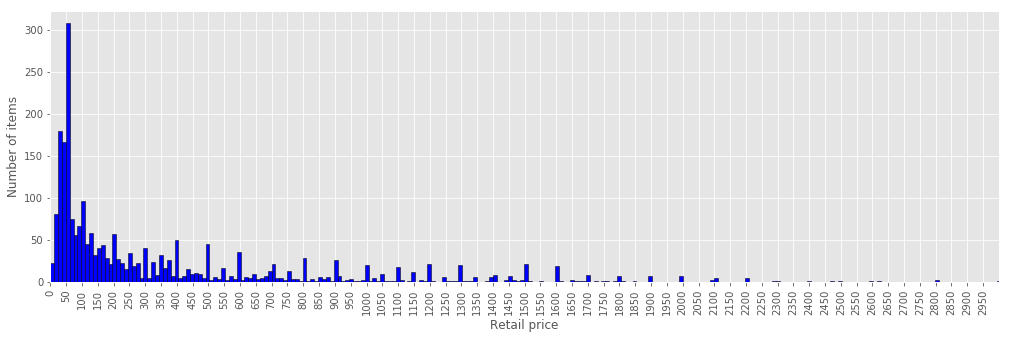

In [67]:
plt.figure(figsize=(17,5))

plt.xticks(np.arange(0, 3000, 50),rotation=90)
plt.hist(descAndRetailPricesCombinations['retail'], color = 'blue', edgecolor = 'black', bins = 2000)
plt.xlim(0,3000)
plt.xlabel('Retail price')
plt.ylabel('Number of items')

The retail price of 500\$ is reached at the 75% percentile of the data:

In [68]:
np.percentile(descAndRetailPricesCombinations['retail'],75)

499.97000000000003

The following robust scaler uses a similar method to the Min-Max scaler, but instead of the maximum and minimum values, it uses percentiles instead, and so it is robust to outliers because it is not influenced by a few number of very large marginal outliers. In this case, the distribution is right skewed and the outliers have been considered to be at the 75% percentile, so the percentiles have been set to 0% and 75%. Of course, this means that it is using less data for scaling.

In [69]:
descAndRetailPricesCombinations = outcomesDf.groupby(['desc','retail']).size().reset_index()
descAndRetailPricesCombinations = descAndRetailPricesCombinations.drop(0,axis=1)
#robust scaler
scaler = preprocessing.RobustScaler(quantile_range=(0.0, 75.0))
retail_std = scaler.fit_transform(pd.DataFrame(descAndRetailPricesCombinations['retail']))

As it can be seen, the median of the scaled prices is zero, in the same way as with the word embedding vectors. Note that the outliers themselves are still present in the transformed data, and so, the minimum and maximum values are not 0 and 1:

In [70]:
print("Minimum value: "+str(np.min(retail_std)))
print("Maximum value: "+str(np.max(retail_std)))
print("Mean value: "+str(np.mean(retail_std)))
print("Median value: "+str(np.median(retail_std)))
print("Standard deviation: "+str(np.std(retail_std)))

Minimum value: -0.29999799988
Maximum value: 48.8029481769
Mean value: 0.465610903552
Median value: 0.0
Standard deviation: 1.36289228409


The word embedding vector length is 300 features. Therefore, the scaled retail prices values have to be multiplied by 300 so that they have a similar weight as the word embedding vectors during the cluster calculation process. 

Since the robust scaler percentiles have been defined as 0% and 75%, only 75% of the data will have a similar weight as the word embedding vectors during the cluster calculation process. The other 25% of data has been considered to contain outliers during the scaling and will have a higher weight than the word embedding vectors during the cluster calculation process. Therefore, some clusters will be formed almost exclusively by the condition that the retail prices of the items belonging to it are extremely high. This behaviour is alright, since items with very high retail prices will most likely reach very high selling prices accordingly, independently of the product category that they belong to.

In the same way as in the previous set of models, the following lines of code calculate the metrics associated to each one of the prediction models using 5-fold cross-validation. During the training part, the retail prices are scaled and the K-Means algorithm is used to obtain clusters for the unique combinations of word embedding vectors and scaled retail prices.

Once that each different item has been assigned a cluster, a one-hot encoded version of the corresponding cluster numbers is added to the training data. The input variables for the prediction models are the retail price of the item, the bid increment, the bid fee, the flags that indicate the type of auction, and the one-hot encoded cluster identifier.

During the test part, the retail prices of the unique combinations of product descriptions and retail prices have to be scaled too. The same scaler instance obtained during the training part is used on the test data to transform it in the same way (with the statistics calculated for the samples in the training set). Then, the nearest cluster obtained during the training part is assigned to each row in the test data. Once that each different row has been assigned a cluster, a one-hot encoded version of the corresponding cluster identifiers is added to the test data. 

The mean absolute error and the median absolute error (as the average of the results obtained for these two metrics over the 5 cross-validation folds) is then calculated for each prediction model. The results are analyzed after the lines of code.


In [71]:
kFoldMedianAbsoluteErrorsRandomForestRegressor = []
kFoldMedianAbsoluteErrorsKNeighborsRegressor = []
kFoldMedianAbsoluteErrorsDecisionTreeRegressor = []
kFoldMedianAbsoluteErrorsLinearRegression = []
kFoldMedianAbsoluteErrorsRANSACRegressor = []

kFoldMeanAbsoluteErrorsRandomForestRegressor = []
kFoldMeanAbsoluteErrorsKNeighborsRegressor = []
kFoldMeanAbsoluteErrorsDecisionTreeRegressor = []
kFoldMeanAbsoluteErrorsLinearRegression = []
kFoldMeanAbsoluteErrorsRANSACRegressor = []

kFoldNumber = 1
kf = KFold(n_splits=5, random_state=1)
for train_index, test_index in kf.split(outcomesDf):
    #5-fold cross-validation
    print("Executing k fold = "+str(kFoldNumber))
    kFoldNumber=kFoldNumber+1
    
    #train and test split
    outcomesDf_train, outcomesDf_test = outcomesDf.iloc[train_index], outcomesDf.iloc[test_index]   
    
    #TRAINING PART
        
    productDescriptionToVector={}
    for item in outcomesDf['desc'].unique():
        #Word2Vec vector obtained for each product description
        productDescriptionToVector[item] = productDescriptionToVectorDf[item]
    
    #DataFrame containing unique combinations of the columns "desc" and "retail" (the same product
    #is auctioned more than once over time, and sometimes it is associated to a different retail price)
    descAndRetailPricesCombinationsTrain = outcomesDf_train.groupby(['desc','retail']).size().reset_index()
    descAndRetailPricesCombinationsTrain = descAndRetailPricesCombinationsTrain.drop(0,axis=1)
    
    #robust scaler
    scaler = preprocessing.RobustScaler(quantile_range=(0, 75.0))
    retail_std = scaler.fit_transform(pd.DataFrame(descAndRetailPricesCombinationsTrain['retail']))
    #Google's pre-trained Word2Vec model vector length is 300 features.
    #Since the 300 features are given as input for the clustering, and the
    #retail price has been scaled,the retail price is multiplied by 300
    #so that it has the same importance for the clustering as the
    #300 vector features altogether.
    descAndRetailPricesCombinationsTrain['retail_std'] = retail_std*300
    
    productVectorColumnValuesAndRetail = []
    for index, row in descAndRetailPricesCombinationsTrain.iterrows():
        #iteration through each unique combination of the columns "desc" and "retail"
        productDescription=row['desc']
        auctionProductVector = np.array(productDescriptionToVector[productDescription])
        #the Word2Vec vector for the product description and the retail price will be given
        #as input for the clustering
        productVectorColumnValuesAndRetail.append(np.append(auctionProductVector,row['retail_std']))
    
    km = KMeans(n_clusters=35,random_state=2)
    #clustering with the Word2Vec vectors and retail prices given as input
    km.fit(productVectorColumnValuesAndRetail)
    clusters = km.labels_.tolist()
    descAndRetailPricesCombinationsTrain['cat_cluster'] = clusters
    
    #One-Hot encoded version of the DataFrame containing a column for each cluster
    clusteredCategoriesDfOneHotEnc = convertCategoryDataFrameToOneHotEncodedVersion(descAndRetailPricesCombinationsTrain,'cat_cluster')  
    
    #column names of the clusters
    cluster_column_names = clusteredCategoriesDfOneHotEnc.columns.values
    
    descAndRetailPricesCombinationsTrain[clusteredCategoriesDfOneHotEnc.columns] = clusteredCategoriesDfOneHotEnc
        
    #the training dataset is merged so that it contains a one hot-encoded 
    #column for each one of the clusters obtained.
    outcomesDfWithCatOneHot = outcomesDf_train.merge(descAndRetailPricesCombinationsTrain,how='left')
    
    normal_x_column_names = ["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]
    #column names to be used in the prediction model: they include the columns corresponding to the clusters obtained.
    column_names_with_clusters = np.concatenate([normal_x_column_names,cluster_column_names])
    
    #training phase variables
    X_train = outcomesDfWithCatOneHot[column_names_with_clusters]
    y_train = outcomesDfWithCatOneHot["price"]
    
    #TEST PART
    
    #DataFrame containing unique combinations of the columns "desc" and "retail" (the same product
    #is auctioned more than once over time, and sometimes it is associated to a different retail price)
    descAndRetailPricesCombinationsTest = outcomesDf_test.groupby(['desc','retail']).size().reset_index()
    descAndRetailPricesCombinationsTest = descAndRetailPricesCombinationsTest.drop(0,axis=1)
    
    #The scaler that is used in the test phase is the one that was obtained during the
    #training phase.
    #The same operations as in the training phase are performed.
    retail_std = scaler.transform(pd.DataFrame(descAndRetailPricesCombinationsTest['retail']))
    descAndRetailPricesCombinationsTest['retail_std'] = retail_std*300
     
    clusters = []
    for index, row in descAndRetailPricesCombinationsTest.iterrows():
        productDescription=row['desc']
        auctionProductVector = np.array(productDescriptionToVector[productDescription])
        productVectorColumnValuesAndRetail = np.append(auctionProductVector,row['retail_std'])
        #The K-Means model obtained during the training phase is used to associate
        #an existing cluster to each one of the combinations of product vectors and retail
        #prices contained in the test data.   
        clusterCategory = km.predict([productVectorColumnValuesAndRetail])
        clusters.append(clusterCategory[0])
        
    descAndRetailPricesCombinationsTest['cat_cluster'] = clusters
    
    #One-Hot encoded version of the DataFrame containing a column for each cluster.
    #The columns are the same ones as in the training phase
    clusteredCategoriesDfOneHotEnc = convertCategoryDataFrameToOneHotEncodedVersion(descAndRetailPricesCombinationsTest,'cat_cluster',cluster_column_names)
  
    #column names of the clusters
    cluster_column_names = clusteredCategoriesDfOneHotEnc.columns.values
    
    descAndRetailPricesCombinationsTest[clusteredCategoriesDfOneHotEnc.columns] = clusteredCategoriesDfOneHotEnc
    
    #the test dataset is merged so that it contains a one hot-encoded 
    #column for each one of the clusters obtained.
    outcomesDfWithCatOneHot = outcomesDf_test.merge(descAndRetailPricesCombinationsTest,how='left')
    
    normal_x_column_names = ["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]
    #column names to be used in the prediction model: they include the columns corresponding to the clusters obtained.
    column_names_with_clusters = np.concatenate([normal_x_column_names,cluster_column_names])
    
    #test phase variables
    X_test = outcomesDfWithCatOneHot[column_names_with_clusters]
    y_test = outcomesDfWithCatOneHot["price"]
    
    #Predictors
    
    #RandomForestRegressor
    model=RandomForestRegressor(random_state=1)
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsRandomForestRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsRandomForestRegressor.append(kFoldMeanAbsoluteError)  

    #KNeighborsRegressor
    model = KNeighborsRegressor()
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsKNeighborsRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsKNeighborsRegressor.append(kFoldMeanAbsoluteError)  
    
    #DecisionTreeRegressor
    model = DecisionTreeRegressor()
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsDecisionTreeRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsDecisionTreeRegressor.append(kFoldMeanAbsoluteError)  
    
    #LinearRegression
    model = LinearRegression()
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsLinearRegression.append(kFoldMedianAbsoluteError) 
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsLinearRegression.append(kFoldMeanAbsoluteError)  
    
    #RANSACRegressor
    model = RANSACRegressor(random_state=1)
    model.fit(X_train,y_train)
    P_price = model.predict(X_test)
    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsRANSACRegressor.append(kFoldMedianAbsoluteError) 
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsRANSACRegressor.append(kFoldMeanAbsoluteError)  
    
medianAbsoluteErrorsRandomForestRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsRandomForestRegressor)
meanAbsoluteErrorsRandomForestRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsRandomForestRegressor)
medianAbsoluteErrorsKNeighborsRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsKNeighborsRegressor)
meanAbsoluteErrorsKNeighborsRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsKNeighborsRegressor)
medianAbsoluteErrorsDecisionTreeRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsDecisionTreeRegressor)
meanAbsoluteErrorsDecisionTreeRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsDecisionTreeRegressor)
medianAbsoluteErrorsLinearRegressionAverage = np.mean(kFoldMedianAbsoluteErrorsLinearRegression)
meanAbsoluteErrorsLinearRegressionAverage = np.mean(kFoldMeanAbsoluteErrorsLinearRegression)
medianAbsoluteErrorsRANSACRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsRANSACRegressor)
meanAbsoluteErrorsRANSACRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsRANSACRegressor)

print("--")
print("Random Forest Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsRandomForestRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsRandomForestRegressorAverage))
print("--")
print("K Neighbors Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsKNeighborsRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsKNeighborsRegressorAverage))
print("--")
print("Decision Tree Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsDecisionTreeRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsDecisionTreeRegressorAverage))
print("--")
print("Linear Regression")
print("Median absolute error: "+str(medianAbsoluteErrorsLinearRegressionAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsLinearRegressionAverage))
print("--")
print("RANSAC Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsRANSACRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsRANSACRegressorAverage))

Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
--
Random Forest Regressor
Median absolute error: 11.1213084905
Mean absolute error: 32.5591795213
--
K Neighbors Regressor
Median absolute error: 11.6736
Mean absolute error: 31.6176039332
--
Decision Tree Regressor
Median absolute error: 11.1622118506
Mean absolute error: 30.0645029178
--
Linear Regression
Median absolute error: 88.90648655
Mean absolute error: 146.484095711
--
RANSAC Regressor
Median absolute error: 38.3213749265
Mean absolute error: 63.4435851497


As it can be seen above, the model with the best results is the decision tree regressor. The random forest regressor and the the k-neighbors regressor perform slightly worse. Ultimately, the RANSAC regressor and the linear regression perform significantly worse.

In general, the results are worse with this set of models as compared with the set of models explained in the previous section.

In terms of effort, this model requires several preprocessing steps: given the product description of an item in the column "desc", its Amazon category must be obtained, and afterwards, the corresponding word embedding vector. Moreover, the retail price of the item has to be scaled before making the prediction.

Appart from the preprocessing steps, during the training part of the model, the clusters and the scaler instance are obtained, and they are later used everytime that a new prediction is made.  After some time, more and more new products will begin to be auctioned, which will not have been considered to form the clusters and to calculate the scaling values.  Because of this, the clusters and the scaler instance may eventually become outdated, and the models will perform worse. Therefore, appart from the preprocessing step, it is necessary to retrain the prediction models from time to time.

For the given dataset, this set of models is not interesting, since it is more complex and performs worse than some of the set of models explained in other sections. As the amount of data increases, it could be interesting to analyze the performance of this set of models again.

# e) Multiple models - Clustering by product categories and retail prices

A fith set of models that calculate clusters based on the product categories and retail prices has been built. The difference between this set of models and the previous one is that instead of using a single model for all items, a different prediction model is used for each different cluster.

In [72]:
outcomesDf = pd.read_csv('./outcomes_clean.tsv',sep='\t')

In [73]:
productDescriptionToVectorDf = pd.read_excel('./productDescriptionToVector.xlsx')

In the same way as in the previous set of models, the following lines of code calculate the metrics associated to each one of the prediction models using 5-fold cross-validation. During the training part, the K-Means algorithm is used to obtain clusters for the unique combinations of product descriptions and retail prices. Once that each different item in the training data has been assigned to a cluster, the training data is divided by cluster identifier. For each set of data belonging to the same cluster, a new set of prediction models is trained. The input variables the retail price of the item, the bid increment, the bid fee and the flags that indicate the type of auction.


During the test part, the nearest cluster is assigned to each row contained in the test data. Then, the corresponding set of models corresponding to that cluster is used to make the selling price prediction.

The mean absolute error and the median absolute error (as the average of the results obtained for these two metrics over the 5 cross-validation folds) is then calculated for each prediction model contained in the different sets assigned to each cluster. For each type of prediction model (random forest regressor, decision tree regressor, etc), the mean absolute error and the median absolute error is calculated as the average of the results obtained for each one of the models (with the same type of prediction algorithm) corresponding to each different cluster. The results are analyzed after the lines of code.

In [74]:
kFoldMedianAbsoluteErrorsRandomForestRegressor = []
kFoldMedianAbsoluteErrorsKNeighborsRegressor = []
kFoldMedianAbsoluteErrorsDecisionTreeRegressor = []
kFoldMedianAbsoluteErrorsLinearRegression = []
kFoldMedianAbsoluteErrorsRANSACRegressor = []

kFoldMeanAbsoluteErrorsRandomForestRegressor = []
kFoldMeanAbsoluteErrorsKNeighborsRegressor = []
kFoldMeanAbsoluteErrorsDecisionTreeRegressor = []
kFoldMeanAbsoluteErrorsLinearRegression = []
kFoldMeanAbsoluteErrorsRANSACRegressor = []

kf = KFold(n_splits=5, random_state=1)
kFoldNumber = 1
for train_index, test_index in kf.split(outcomesDf):
    #5-fold cross-validation
    print("Executing k fold = "+str(kFoldNumber))
    kFoldNumber=kFoldNumber+1
    
    #train and test split
    outcomesDf_train, outcomesDf_test = outcomesDf.iloc[train_index], outcomesDf.iloc[test_index]   
    
    #TRAINING PART
    
    productDescriptionToVector={}
    for item in outcomesDf['desc'].unique():
        #Word2Vec vector obtained for each product description
        productDescriptionToVector[item] = productDescriptionToVectorDf[item]
     
    #DataFrame containing unique combinations of the columns "desc" and "retail" (the same product
    #is auctioned more than once over time, and sometimes it is associated to a different retail price)
    descAndRetailPricesCombinationsTrain = outcomesDf_train.groupby(['desc','retail']).size().reset_index()
    descAndRetailPricesCombinationsTrain = descAndRetailPricesCombinationsTrain.drop(0,axis=1)
    
    #robust scaler
    scaler = preprocessing.RobustScaler(quantile_range=(0, 75.0))
    retail_std = scaler.fit_transform(pd.DataFrame(descAndRetailPricesCombinationsTrain['retail']))
    
    #Google's pre-trained Word2Vec model vector length is 300 features.
    #Since the 300 features are given as input for the clustering, and the
    #retail price has been scaled,the retail price is multiplied by 300
    #so that it has the same importance for the clustering as the
    #300 vector features altogether.
    descAndRetailPricesCombinationsTrain['retail_std'] = retail_std*300
       
    productVectorColumnValuesAndRetail = []
    for index, row in descAndRetailPricesCombinationsTrain.iterrows():
        #iteration through each unique combination of the columns "desc" and "retail"
        productDescription=row['desc']
        auctionProductVector = np.array(productDescriptionToVector[productDescription])
        #the Word2Vec vector for the product description and the retail price will be given
        #as input for the clustering
        productVectorColumnValuesAndRetail.append(np.append(auctionProductVector,row['retail_std']))
    
    km = KMeans(n_clusters=20,random_state=2)
    #clustering with the Word2Vec vectors and retail prices given as input
    km.fit(productVectorColumnValuesAndRetail)
    clusters = km.labels_.tolist()
    descAndRetailPricesCombinationsTrain['cat_cluster'] = clusters
    #the training dataset is merged and now it contains a column with the cluster that
    #each product belongs to.
    outcomesDfTrainAndCatCluster = outcomesDf_train.merge(descAndRetailPricesCombinationsTrain,how='left')

    clusterIndexToOutcomesDfTrain = {}
    for cluster_index in outcomesDfTrainAndCatCluster['cat_cluster'].unique():
        #the rows associated to each different cluster are stored in a dictionary,
        #where the dictionary key is the cluster number
        clusterIndexToOutcomesDfTrain[cluster_index] = outcomesDfTrainAndCatCluster[outcomesDfTrainAndCatCluster['cat_cluster'] == cluster_index]
    
    #dictionaries that contain a trained model for each one of the clusters
    clusterIndexToRandomForestRegressor = {}
    clusterIndexToKNeighborsRegressor = {}
    clusterIndexToDecisionTreeRegressor = {}
    clusterIndexToLinearRegression = {}
    clusterIndexToRANSACRegressor = {}
    
    for cluster_index, outcomesDfClusterIndex in clusterIndexToOutcomesDfTrain.items():
        #For each cluster, a different model is trained using
        #the rows of the input dataset containing the products associated to that cluster
        X_train = outcomesDfClusterIndex[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]].values
        y_train = outcomesDfClusterIndex["price"]
        
        #RandomForestRegressor
        model=RandomForestRegressor(random_state=1)
        model.fit(X_train,y_train)
        clusterIndexToRandomForestRegressor[cluster_index] = model

        #KNeighborsRegressor
        n_neighbors=5
        if outcomesDfClusterIndex.shape[0] < n_neighbors:
            #In KNeighborsRegressor it is expected n_neighbors <= n_samples
            n_neighbors = outcomesDfClusterIndex.shape[0]
            
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
        model.fit(X_train,y_train)
        clusterIndexToKNeighborsRegressor[cluster_index] = model

        #DecisionTreeRegressor
        model = DecisionTreeRegressor()
        model.fit(X_train,y_train)
        clusterIndexToDecisionTreeRegressor[cluster_index] = model
    
        #LinearRegression
        model = LinearRegression()
        model.fit(X_train,y_train)
        clusterIndexToLinearRegression[cluster_index] = model
        
        #RANSACRegressor
        model = RANSACRegressor(random_state=1)
        # assume linear model by default
        min_samples = X_train.shape[1] + 1
        if min_samples > X_train.shape[0]:
            #min_samples may not be larger than number X_train.shape[0]
            min_samples = X_train.shape[0]
            model = RANSACRegressor(min_samples=min_samples,random_state=1)
        try:
            model.fit(X_train,y_train)
            clusterIndexToRANSACRegressor[cluster_index] = model
        except Exception as e: 
            continue
        
    #TEST PART
    
    #DataFrame containing unique combinations of the columns "desc" and "retail" (the same product
    #is auctioned more than once over time, and sometimes it is associated to a different retail price)
    descAndRetailPricesCombinationsTest = outcomesDf_test.groupby(['desc','retail']).size().reset_index()
    descAndRetailPricesCombinationsTest = descAndRetailPricesCombinationsTest.drop(0,axis=1)
    
    #The scaler that is used in the test phase is the one that was obtained during the
    #training phase.
    #The same operations as in the training phase are performed.
    retail_std = scaler.transform(pd.DataFrame(descAndRetailPricesCombinationsTest['retail']))
    descAndRetailPricesCombinationsTest['retail_std'] = retail_std*300
     
    clusters = []
    for index, row in descAndRetailPricesCombinationsTest.iterrows():
        productDescription=row['desc']
        auctionProductVector = np.array(productDescriptionToVector[productDescription])
        productVectorColumnValuesAndRetail = np.append(auctionProductVector,row['retail_std'])
        #The K-Means model obtained during the training phase is used to associate
        #an existing cluster to each one of the combinations of product vectors and retail
        #prices contained in the test data.   
        clusterCategory = km.predict([productVectorColumnValuesAndRetail])
        clusters.append(clusterCategory[0])
        
    descAndRetailPricesCombinationsTest['cat_cluster'] = clusters
    #the test dataset is merged and now it contains a column with the cluster that
    #each product belongs to.
    outcomesDfTestAndCatCluster = outcomesDf_test.merge(descAndRetailPricesCombinationsTest,how='left')
    
    realAndPredictedValuesRandomForestRegressor = []
    realAndPredictedValuesKNeighborsRegressor = []
    realAndPredictedValuesDecisionTreeRegressor = []
    realAndPredictedValuesLinearRegression = []
    realAndPredictedValuesRANSACRegressor = []
    
    for index, row in outcomesDfTestAndCatCluster.iterrows():
        #iteration through each row of the test dataset
        
        #real value of the column to be predicted
        y_test_value = row["price"]
        #values given as input for the prediction model
        x_test_value = row[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]].values
        #product category cluster for this row of the dataset
        clusterIndex = row["cat_cluster"]

        #the prediction models associated to this cluster are extracted
        modelRandomForestRegressor = clusterIndexToRandomForestRegressor[clusterIndex]
        modelKNeighborsRegressor = clusterIndexToKNeighborsRegressor[clusterIndex]
        modelDecisionTreeRegressor = clusterIndexToDecisionTreeRegressor[clusterIndex]
        modelLinearRegression = clusterIndexToLinearRegression[clusterIndex]
        
        realAndPredictedValuesRandomForestRegressor.append((y_test_value,modelRandomForestRegressor.predict([x_test_value])[0]))
        realAndPredictedValuesKNeighborsRegressor.append((y_test_value,modelKNeighborsRegressor.predict([x_test_value])[0]))
        realAndPredictedValuesDecisionTreeRegressor.append((y_test_value,modelDecisionTreeRegressor.predict([x_test_value])[0]))
        realAndPredictedValuesLinearRegression.append((y_test_value,modelLinearRegression.predict([x_test_value])[0]))
        
        if clusterIndex not in clusterIndexToRANSACRegressor:
            print("clusterIndex not in clusterIndexToRANSACRegressor")
            continue
        modelRANSACRegressor = clusterIndexToRANSACRegressor[clusterIndex]
        realAndPredictedValuesRANSACRegressor.append((y_test_value,modelRANSACRegressor.predict([x_test_value])[0]))
    
    #RandomForestRegressor
    #all real and predicted values are extracted and the metrics are calculated
    y_test, P_price = zip(*realAndPredictedValuesRandomForestRegressor)    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsRandomForestRegressor.append(kFoldMedianAbsoluteError) 
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsRandomForestRegressor.append(kFoldMeanAbsoluteError) 
    
    #KNeighborsRegressor
    #all real and predicted values are extracted and the metrics are calculated
    y_test, P_price = zip(*realAndPredictedValuesKNeighborsRegressor)    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsKNeighborsRegressor.append(kFoldMedianAbsoluteError) 
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsKNeighborsRegressor.append(kFoldMeanAbsoluteError) 
    
    #DecisionTreeRegressor
    #all real and predicted values are extracted and the metrics are calculated
    y_test, P_price = zip(*realAndPredictedValuesDecisionTreeRegressor)    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsDecisionTreeRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsDecisionTreeRegressor.append(kFoldMeanAbsoluteError) 
    
    #LinearRegression
    #all real and predicted values are extracted and the metrics are calculated
    y_test, P_price = zip(*realAndPredictedValuesLinearRegression)    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsLinearRegression.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsLinearRegression.append(kFoldMeanAbsoluteError) 
    
    #RANSACRegressor
    #all real and predicted values are extracted and the metrics are calculated
    y_test, P_price = zip(*realAndPredictedValuesRANSACRegressor)    
    kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
    kFoldMedianAbsoluteErrorsRANSACRegressor.append(kFoldMedianAbsoluteError)
    kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
    kFoldMeanAbsoluteErrorsRANSACRegressor.append(kFoldMeanAbsoluteError) 
    
medianAbsoluteErrorsRandomForestRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsRandomForestRegressor)
meanAbsoluteErrorsRandomForestRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsRandomForestRegressor)
medianAbsoluteErrorsKNeighborsRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsKNeighborsRegressor)
meanAbsoluteErrorsKNeighborsRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsKNeighborsRegressor)
medianAbsoluteErrorsDecisionTreeRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsDecisionTreeRegressor)
meanAbsoluteErrorsDecisionTreeRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsDecisionTreeRegressor)
medianAbsoluteErrorsLinearRegressionAverage = np.mean(kFoldMedianAbsoluteErrorsLinearRegression)
meanAbsoluteErrorsLinearRegressionAverage = np.mean(kFoldMeanAbsoluteErrorsLinearRegression)
medianAbsoluteErrorsRANSACRegressorAverage = np.mean(kFoldMedianAbsoluteErrorsRANSACRegressor)
meanAbsoluteErrorsRANSACRegressorAverage = np.mean(kFoldMeanAbsoluteErrorsRANSACRegressor)

print("--")
print("Random Forest Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsRandomForestRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsRandomForestRegressorAverage))
print("--")
print("K Neighbors Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsKNeighborsRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsKNeighborsRegressorAverage))
print("--")
print("Decision Tree Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsDecisionTreeRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsDecisionTreeRegressorAverage))
print("--")
print("Linear Regression")
print("Median absolute error: "+str(medianAbsoluteErrorsLinearRegressionAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsLinearRegressionAverage))
print("--")
print("RANSAC Regressor")
print("Median absolute error: "+str(medianAbsoluteErrorsRANSACRegressorAverage))
print("Mean absolute error: "+str(meanAbsoluteErrorsRANSACRegressorAverage))

Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
--
Random Forest Regressor
Median absolute error: 11.0684002025
Mean absolute error: 29.3948295166
--
K Neighbors Regressor
Median absolute error: 11.7728
Mean absolute error: 32.707053489
--
Decision Tree Regressor
Median absolute error: 11.1026592998
Mean absolute error: 29.8625242794
--
Linear Regression
Median absolute error: 12.3694147353
Mean absolute error: 32.0224389864
--
RANSAC Regressor
Median absolute error: 10.6948726442
Mean absolute error: 32.986749555


As it can be seen above, the model with the best results in terms of the median absolute error is the RANSAC regressor, while the model with the best results in terms of the mean absolute error is the random forest regressor. The results for the decision tree regressor are very similar to the ones obtained with the random forest regressor. The k-neighbors regressor results are, although worse, very similar too. The worst results are obtained with the linear regression.

In general, the results obtained with this set of models are worse than the the results obtained with the set of models in other sections.

In terms of effort, this model requires several preprocessing steps: given the product description of an item in the column "desc", its Amazon category must be obtained, and afterwards, the corresponding word embedding vector. Moreover, the retail price of the item has to be scaled before making the prediction.

Appart from the preprocessing steps, during the training part of the model, the clusters and the scaler instance are obtained, and they are later used everytime that a new prediction is made.  After some time, more and more new products will begin to be auctioned, which will not have been considered to form the clusters and to calculate the scaling values.  Because of this, the clusters and the scaler instance may eventually become outdated, and the models will perform worse. Therefore, appart from the preprocessing step, it is necessary to retrain the prediction models from time to time.

As compared with the previous section in which a single model is used, the results obtained with multiple models in this section are better, but when retraining is necessary, multipled models have to be retrained instead of just one. 

For the given dataset, this set of models is not interesting, since it is more complex and performs worse than some of the set of models explained in other sections. As the amount of data increases, it could be interesting to analyze the performance of this set of models again.

# Choosing and optimizing the final model

The results of the different models have been analyzed in the above sections. An important remark is that the chosen values for the different variables used in each section have an impact on the results. These variables include: the input parameters of the prediction model algorithms, the number of folds used for the k-fold cross-validation, the number of clusters given as input for the K-Means algorithm for the models that depend on clustering of the data, the input parameters for the scaler algorithm for the models that depend on scaling the input data, etc. 

All of these variables should ideally be opmitized according to the metric that defines the quality of the prediction model (for example, using the GridSearchCV function available in the sklearn library). This requires a lot of time, since there are a lot of possible combinations for all parameter values. For the input parameters of the prediction models, the default parameter values have been used in the results calculated above, except for the random state that has been set to the same value everytime. The number of clusters for the the K-Means algorithm has been manually modified to find the number of clusters that optimizes the result for the values that have been tried.

In general, the random forest regressor and the decision tree regressor are the algorithms that normally provide the best results. These two models are relatively robust to outliers, since they isolate atypical observations into small leaves. The random forest regressor generally performs a bit better than the decision tree regressor and is less likely to overfit the data. The disadvantage is that random forest regressor are more difficult to interpret than decision tree regressors.

Two different clustering options have been analyzed: one that uses the word embedding vectors to cluster the items according to their product categories, and another one that, appart from the word embedding vectors, it also uses the retail prices of the items to obtain the clusters.

With the available data, the model that obtains the clusters by only using as input the word embedding vectors performs better. Moreover, it also requires less preprocessing steps and having to retrain the model less often.

The results obtained with the models that take into account the product categories are better than the ones obtained with the models that do not take them into account.

Nevertheless, taking into account the product categories requires a bigger effort, since a preprocessing step is necessary to make a new prediction: given the product description of an item in the column "desc", its Amazon category must be obtained, and afterwards, the corresponding word embedding vector.

Furthermore, the clusters product category clusters obtained during the trianing part of the model are the ones that are used each time that a new prediction is made. After some time, more and more new products will begin to be auctioned and the clusters may eventually become outdated, causing the model to perform worse. Therefore, appart from the preprocessing step, using the product categories also involves having to retrain the prediction model from time to time.

For the models that take only take into account the word embedding vectors to form the clusters, two different versions have been analyzed: one consisting on a single prediction model and another one that consists on a set of different models, where the model chosen to make every prediction depends on the cluster that each row in the test data belongs to.

The results obtained with the set of multiple models were slightly better than the ones obtained when using a single model. Nevertheless, one of the prediction models corresponding to a certain cluster might perform much worse than the others. 

Also, in both versions, the clusters will eventually become outdated, and when a retraining is necessary, a single prediction model will have to be retrained in one of the versions, while in the other one, as many prediction models as existing clusters will have to be retrained. Considering this disadvantage, as well as the bigger complexity that using a set of multiple models implies, and the fact that the results are fairly similar for both versions, it has been decided to choose the version consisting on a single prediction model as the final one.

Therefore, the final chosen set of models is the one explained in section "b) One Model - Having into account the categories". Of the different prediction algorithms used in that section, the one with the best results is the random forest regressor. This is the one that has been implemented as the final model.

The variables that have a clear impact on the results for this model are: the number of clusters chosen for the K-Means clustering algorithm, as well as the input parameters for the random forest regressor. A grid of different values for the number of clusters and the number of trees used in the random forest algorithm has been created.

In [75]:
outcomesDf = pd.read_csv('./outcomes_clean.tsv',sep='\t')

In [76]:
productDescriptionToVectorDf = pd.read_excel('./productDescriptionToVector.xlsx')

In [77]:
kFoldMedianAbsoluteErrorsRandomForestRegressor = {}
kFoldMeanAbsoluteErrorsRandomForestRegressor = {}

nClusterGrid = [10,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
#nClusterGrid = [15]
nEstimatorsGrid=[10,15]

gridTotalCombinations = len(nClusterGrid)*len(nEstimatorsGrid)
gridCombinationNumber = 1

for nClustersGridValue in nClusterGrid:
    for nEstimatorsGridValue in nEstimatorsGrid:
        gridCombinationString = str(nClustersGridValue)+"-"+str(nEstimatorsGridValue)
        print("Executing grid combination "+str(gridCombinationNumber)+" out of "+str(gridTotalCombinations)+" combinations")
        gridCombinationNumber=gridCombinationNumber+1

        kFoldNumber = 1
        kf = KFold(n_splits=5, random_state=1)
        for train_index, test_index in kf.split(outcomesDf):
            #5-fold cross-validation
            print("Executing k fold = "+str(kFoldNumber))
            kFoldNumber=kFoldNumber+1

            #train and test split
            outcomesDf_train, outcomesDf_test = outcomesDf.iloc[train_index], outcomesDf.iloc[test_index]   

            #TRAINING PART

            #Unique product descriptions present in the training dataset
            productDescriptionTrain = outcomesDf_train['desc'].unique()

            productDescriptionToVector={}
            for item in productDescriptionTrain:
                #Word2Vec vector obtained for each product description
                productDescriptionToVector[item] = productDescriptionToVectorDf[item]

            productVectors = list(productDescriptionToVector.values())

            km = KMeans(n_clusters=nClustersGridValue,random_state=2)
            #the clustering is performed with the Word2Vec vectors for the product categories given as input
            km.fit(productVectors)
            clusters = km.labels_.tolist()
            #DataFrame containing columns for the product description and the category cluster that it is associated to
            clusteredCategoriesDf = pd.DataFrame({'desc': list(productDescriptionToVector.keys()), 'cat_cluster': clusters})
            #One-Hot encoded version of the DataFrame containing a column for each cluster
            clusteredCategoriesDfOneHotEnc = convertCategoryDataFrameToOneHotEncodedVersion(clusteredCategoriesDf,'cat_cluster')  
            #column names of the clusters
            cluster_column_names = clusteredCategoriesDfOneHotEnc.columns.values
            clusteredCategoriesDfOneHotEnc['desc'] = clusteredCategoriesDf['desc']
            #the training dataset is merged so that it contains a one hot-encoded 
            #column for each one of the clusters obtained.
            outcomesDfWithCatOneHot = outcomesDf_train.merge(clusteredCategoriesDfOneHotEnc,how='left')
            normal_x_column_names = ["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]
            #column names to be used in the prediction model: they include the columns corresponding to the clusters obtained.
            column_names_with_clusters = np.concatenate([normal_x_column_names,cluster_column_names])

            #training phase variables
            X_train = outcomesDfWithCatOneHot[column_names_with_clusters]
            y_train = outcomesDfWithCatOneHot["price"]

            #TEST PART

            #Unique product descriptions present in the training dataset
            productDescriptionTest = outcomesDf_test['desc'].unique()

            productDescriptionToVector={}
            for item in productDescriptionTest:
                #Word2Vec vector obtained for each product description
                productDescriptionToVector[item] = productDescriptionToVectorDf[item]

            productDescriptionToTrainCluster = {}
            for productDescription, vector in productDescriptionToVector.items():
                #The K-Means model obtained during the training phase is used to associate
                #an existing cluster to each one of the product vectors contained in the test data.
                clusterCategory = km.predict([vector])
                productDescriptionToTrainCluster[productDescription] = clusterCategory[0]

            #DataFrame containing columns for the product description and the category cluster that it is associated to
            clusteredCategoriesDf = pd.DataFrame(list(productDescriptionToTrainCluster.items()), columns=['desc', 'cat_cluster'])
            #One-Hot encoded version of the DataFrame containing a column for each cluster.
            #The columns are the same ones as in the training phase
            clusteredCategoriesDfOneHotEnc = convertCategoryDataFrameToOneHotEncodedVersion(clusteredCategoriesDf,'cat_cluster',cluster_column_names)
            #column names of the clusters
            cluster_column_names = clusteredCategoriesDfOneHotEnc.columns.values
            clusteredCategoriesDfOneHotEnc['desc'] = clusteredCategoriesDf['desc']
            #the test dataset is merged so that it contains a one hot-encoded 
            #column for each one of the clusters obtained.
            outcomesDfWithCatOneHot = outcomesDf_test.merge(clusteredCategoriesDfOneHotEnc,how='left')
            normal_x_column_names = ["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]
            #column names to be used in the prediction model: they include the columns corresponding to the clusters obtained.
            column_names_with_clusters = np.concatenate([normal_x_column_names,cluster_column_names])

            #test phase variables
            X_test = outcomesDfWithCatOneHot[column_names_with_clusters]
            y_test = outcomesDfWithCatOneHot["price"]

            #Predictors

            #RandomForestRegressor
            model=RandomForestRegressor(random_state=1, n_estimators=nEstimatorsGridValue)
            model.fit(X_train,y_train)
            P_price = model.predict(X_test)

            kFoldMedianAbsoluteError = median_absolute_error(y_test,P_price)
            if gridCombinationString not in kFoldMedianAbsoluteErrorsRandomForestRegressor:
                kFoldMedianAbsoluteErrorsRandomForestRegressor[gridCombinationString] = []
            kFoldMedianAbsoluteErrorsRandomForestRegressor[gridCombinationString].append(kFoldMedianAbsoluteError)               
            
            kFoldMeanAbsoluteError = mean_absolute_error(y_test,P_price)
            if gridCombinationString not in kFoldMeanAbsoluteErrorsRandomForestRegressor:
                kFoldMeanAbsoluteErrorsRandomForestRegressor[gridCombinationString] = []
            kFoldMeanAbsoluteErrorsRandomForestRegressor[gridCombinationString].append(kFoldMeanAbsoluteError)

Executing grid combination 1 out of 30 combinations
Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
Executing grid combination 2 out of 30 combinations
Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
Executing grid combination 3 out of 30 combinations
Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
Executing grid combination 4 out of 30 combinations
Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
Executing grid combination 5 out of 30 combinations
Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
Executing grid combination 6 out of 30 combinations
Executing k fold = 1
Executing k fold = 2
Executing k fold = 3
Executing k fold = 4
Executing k fold = 5
Executing grid combination 7 out of 30 combinations
Execut

In [78]:
minMedianAbsoluteError = None
minMedianAbsoluteErrorKey = None
meanAbsoluteErrorWithMinMedianAbsoluteError = None


minMeanAbsoluteError= None
minMeanAbsoluteErrorKey = None
medianAbsoluteErrorWithMinMeanAbsoluteError = None


for key, value in kFoldMedianAbsoluteErrorsRandomForestRegressor.items():
    nClustersGridValue = key[0:2]
    nEstimatorsGridValue = key[-2:]
    print("N clusters = " + str(nClustersGridValue) + " ; N estimators = "+str(nEstimatorsGridValue))
    
    kFoldMedianAbsoluteErrorsRandomForestRegressorCurrentCombination = kFoldMedianAbsoluteErrorsRandomForestRegressor[key]
    kFoldMeanAbsoluteErrorsRandomForestRegressorCurrentCombination = kFoldMeanAbsoluteErrorsRandomForestRegressor[key]    
    
    combinationMedianAbsoluteError = np.mean(kFoldMedianAbsoluteErrorsRandomForestRegressorCurrentCombination)
    combinationMeanAbsoluteError = np.mean(kFoldMeanAbsoluteErrorsRandomForestRegressorCurrentCombination)
    
    if minMedianAbsoluteError is None:
        minMedianAbsoluteError = combinationMedianAbsoluteError
        minMedianAbsoluteErrorKey = key
        meanAbsoluteErrorWithMinMedianAbsoluteError = combinationMeanAbsoluteError       
    elif combinationMedianAbsoluteError < minMedianAbsoluteError:
        minMedianAbsoluteError = combinationMedianAbsoluteError
        minMedianAbsoluteErrorKey = key     
        meanAbsoluteErrorWithMinMedianAbsoluteError = combinationMeanAbsoluteError
            
    if minMeanAbsoluteError is None:
        minMeanAbsoluteError = combinationMeanAbsoluteError
        minMeanAbsoluteErrorKey = key
        medianAbsoluteErrorWithMinMeanAbsoluteError = combinationMedianAbsoluteError
    elif combinationMeanAbsoluteError < minMeanAbsoluteError:
        minMeanAbsoluteError = combinationMeanAbsoluteError
        minMeanAbsoluteErrorKey = key
        medianAbsoluteErrorWithMinMeanAbsoluteError = combinationMedianAbsoluteError
    
    print("Median absolute error = " + str(combinationMedianAbsoluteError))
    print("Mean absolute error   = " + str(combinationMeanAbsoluteError))
      
    print("--")

N clusters = 10 ; N estimators = 10
Median absolute error = 10.4600742337
Mean absolute error   = 28.3928103559
--
N clusters = 10 ; N estimators = 15
Median absolute error = 10.4541755616
Mean absolute error   = 28.3287636468
--
N clusters = 12 ; N estimators = 10
Median absolute error = 10.4121693664
Mean absolute error   = 28.3481462479
--
N clusters = 12 ; N estimators = 15
Median absolute error = 10.4060284261
Mean absolute error   = 28.2630361398
--
N clusters = 13 ; N estimators = 10
Median absolute error = 10.5492960772
Mean absolute error   = 28.3659670918
--
N clusters = 13 ; N estimators = 15
Median absolute error = 10.5536345395
Mean absolute error   = 28.2897791786
--
N clusters = 14 ; N estimators = 10
Median absolute error = 10.4384989764
Mean absolute error   = 28.3397031232
--
N clusters = 14 ; N estimators = 15
Median absolute error = 10.457491468
Mean absolute error   = 28.2555242302
--
N clusters = 15 ; N estimators = 10
Median absolute error = 10.5067559321
Mean ab

In [79]:
minMedianAbsoluteErrorNClustersGridValue = minMedianAbsoluteErrorKey[0:2]
minMedianAbsoluteErrorNEstimatorsGridValue = minMedianAbsoluteErrorKey[-2:]

print('The optimal median absolute error is ' + str(minMedianAbsoluteError) + " with " + str(minMedianAbsoluteErrorNClustersGridValue) + " clusters and " + str(minMedianAbsoluteErrorNEstimatorsGridValue) + " estimators.")
print('With this combination the mean absolute error is '+str(meanAbsoluteErrorWithMinMedianAbsoluteError))
minMeanAbsoluteErrorNClustersGridValue = minMeanAbsoluteErrorKey[0:2]
minMeanAbsoluteErrorNEstimatorsGridValue = minMeanAbsoluteErrorKey[-2:]
print("---")
print('The optimal median absolute error is ' + str(minMeanAbsoluteError) +" with " + str(minMeanAbsoluteErrorNClustersGridValue) +" clusters and " + str(minMeanAbsoluteErrorNEstimatorsGridValue) + " estimators.")
print('With this combination the median absolute error is '+str(medianAbsoluteErrorWithMinMeanAbsoluteError))

The optimal median absolute error is 10.3695943096 with 20 clusters and 10 estimators.
With this combination the mean absolute error is 28.2917930555
---
The optimal median absolute error is 28.2082201044 with 16 clusters and 15 estimators.
With this combination the median absolute error is 10.4295892271


As it has been mentioned at the beginning of this document when the metrics have been introduced, the median absolute error is considered to be more important for auction selling price predictions. Therefore, the optimal parameters and the final metric results are:

In [80]:
print("Chosen set of models : "+"b) One Model - Having into account the categories")
print("Chosen model : "+"Random forest regressor")
print("K-Means -> N clusters = "+str(minMedianAbsoluteErrorNClustersGridValue))
print("Random forest regressor -> N estimators  = "+str(minMedianAbsoluteErrorNEstimatorsGridValue))
print("Median absolute error = "+str( minMedianAbsoluteError))
print("Mean absolute error = "+str(meanAbsoluteErrorWithMinMedianAbsoluteError))

Chosen set of models : b) One Model - Having into account the categories
Chosen model : Random forest regressor
K-Means -> N clusters = 20
Random forest regressor -> N estimators  = 10
Median absolute error = 10.3695943096
Mean absolute error = 28.2917930555
